This code runs nicely locally.

In [110]:
# Pretty much all of this code is recycled from the course notes with slight modifications.
# I wanted to thank the Professor for providing the excellent notes.
# What follows is an introductory adventure through data exploration, preprocessing, and embedding.

In [102]:
# Import Spacy and pandas
import spacy
import pandas as pd

# Load the spaCy model
nlp = spacy.load('en_core_web_lg')

In [103]:
#Load the full data set into the variable data
data = pd.read_csv('WELFake_Dataset.csv', header = 0)

In [104]:
# For this project we only need a sample size of 4000-5000. So lets reduce the size of our sample.
data = data[:5000]

In [105]:
# Percentage that are true
true_percentage = data['label'].sum()/data['label'].count()

print("Percentage that are true: ", true_percentage)
print("Percentage that are false: ", (1-true_percentage))

Percentage that are true:  0.5256
Percentage that are false:  0.47440000000000004


In [106]:
# For this project we are only interested in the text, not the labels, or titles so we will remove all the unnecesary information
data = data.drop(['Unnamed: 0','title'], axis=1)


In [107]:
# Inspect the first few elements of what remains
data.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [108]:
# Store all the news articles in an array of docs called docs.
docs = []
for doc in data['text']:
    docs.append(doc)

In [109]:
# This is the processing stream from project 1
def preprocessing2(text):
    
    doc = nlp(str(text))

    tokens_clean = []

    # For each token
    for token in doc:

        #Remove stop words, digits, and spaces, punctuation.
        if ((((not token.is_stop) and (not token.is_digit)) and (not token.is_space)) and (not token.is_punct)):

            # https://stackoverflow.com/questions/63283128/how-determine-if-a-token-is-part-of-an-entity-within-spacy
            # Info about named ent
            # Lowercase if it is not a named entity
            if (token.ent_type_ != ""):
            
                #If the token is a named entity then we can safetly append it.
                tokens_clean.append(token.lemma_)

            else:

                #If the token is not a named entity then we can lemmatize it
                tokens_clean.append(token.lemma_)
            
            
    
    tokens_clean = ' '.join(tokens_clean)
    
    return tokens_clean   


# Write a function to do lmmatization, tokenization, named_entity recognition, and depencencies
text = 'The last night, many people celebrate with thier HI trump friends Trump in the Halloween party.'
tokens_cleaned = preprocessing2(text)
print('Original Text is:', text)
print('tokens_cleaned:', tokens_cleaned)

Original Text is: The last night, many people celebrate with thier HI trump friends Trump in the Halloween party.
tokens_cleaned: night people celebrate thier HI trump friend Trump Halloween party


In [110]:
# This will create a new column of clean text
for i in range(len(data['text'])):

    data.loc[i, 'clean'] = preprocessing2(data.loc[i , 'text'])

In [80]:
data.head()

,text,label,clean
0,No comment is expected from Barack Obama Membe...,1,comment expect Barack Obama Members FYF911 fuk...
1,Did they post their votes for Hillary already?,1,post vote Hillary
2,"Now, most of the demonstrators gathered last ...",1,demonstrator gather night exercise constitutio...
3,A dozen politically active pastors came here f...,0,dozen politically active pastor come private d...
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,rs-28 Sarmat missile dub Satan replace SS-18 f...
...,...,...,...
4995,DHAKA (Reuters) - Bangladesh is seeking intern...,0,DHAKA Reuters Bangladesh seek international su...
4996,WASHINGTON (Reuters) - The Republican chairman...,0,WASHINGTON Reuters republican chairman U.S. Fe...
4997,Posted 10/31/2016 2:37 pm by PatriotRising wit...,1,post 10/31/2016 2:37 pm patriotrise comment Cl...
4998,Oregon Standoff Leaders Acquitted For Malheur ...,1,Oregon Standoff leader acquit Malheur Wildlife...


In [111]:
# Store the labels and cleaned documens in arrays for ease of access
labels = []
cleaned = []

for i in range(len(data)):

    labels.append(data.loc[i, 'label'])
    cleaned.append(data.loc[i, 'clean'])

In [112]:
# This is where project2 begins
from spacy.pipeline.textcat import Config, single_label_cnn_config
from spacy.training.example import Example
from spacy.util import minibatch
import random

# Load a spaCy model
nlp = spacy.blank("en")  # Start with a blank English model

# This is out of the text classification notes from class
# Add the text categorization component
config = Config().from_str(single_label_cnn_config)  # Example config for single label classification
textcat = nlp.add_pipe("textcat", config=config, last=True)
textcat.add_label("FAKE")
textcat.add_label("REAL")

1

In [113]:
# 0 is fake, 1 is real

In [114]:
# This code will take the cleaned text, and labels and format it correctly for spacy

train_data = []

for i in range(len(cleaned)):
    
    text = cleaned[i]
    label = labels[i]
    #print(text)
    #print(label)
    
    if (label == 1):
        
        cats = {"cats": {"FAKE": 0, "REAL": 1}}
        
    elif (label == 0):
        
        cats = {"cats": {"FAKE": 1, "REAL": 0}}
        
    #print(cats)
    
    train = (text, cats)
    
    #print(train)
    
    train_data.append(train)
    
    

In [115]:
# Seperate the training and testing data
# traininging data contains the first 4000 records
# testing data contains the last 1000 records
test_data = train_data[4000:]
train_data = train_data[:4000]

In [116]:
len(train_data)

4000

In [117]:
len(test_data)

1000

In [118]:
# This is out of the course notes its just code for setting up and running the spacy text classification 

def nn_spacy(num_epochs, batch_size, data_train):
    
    random.shuffle(data_train)
    
    # Training the text categorization model
    optimizer = nlp.initialize()
    tot_loss = []
    for epoch in range(num_epochs):  # Number of training epochs
        losses = {}
        batches = minibatch(data_train, size=batch_size)
        for batch in batches:
            examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in batch]
            nlp.update(examples, drop=0.5, losses=losses, sgd=optimizer)
        print("Epoch: ", epoch, "Loss: ", losses['textcat'])
        tot_loss.append(losses['textcat'])

    return tot_loss, nlp

In [119]:
# Run the above model with 20 epochs, and batch size 16
tot_loss, nlp =  nn_spacy(20, 16, train_data)

Epoch:  0 Loss:  43.123623203486204
Epoch:  1 Loss:  26.9800122466404
Epoch:  2 Loss:  18.625482797629957
Epoch:  3 Loss:  16.5266630240003
Epoch:  4 Loss:  14.401819896433153
Epoch:  5 Loss:  12.553405070967528
Epoch:  6 Loss:  10.702070644534949
Epoch:  7 Loss:  8.773638045174238
Epoch:  8 Loss:  8.164273936025719
Epoch:  9 Loss:  8.33875596048994
Epoch:  10 Loss:  7.809038201063151
Epoch:  11 Loss:  6.301050900091797
Epoch:  12 Loss:  6.073519174901499
Epoch:  13 Loss:  4.718709523088513
Epoch:  14 Loss:  5.343230082725389
Epoch:  15 Loss:  4.524095178591638
Epoch:  16 Loss:  4.164050819505827
Epoch:  17 Loss:  2.9783354362271908
Epoch:  18 Loss:  3.1172343651143284
Epoch:  19 Loss:  3.0418694256635774


Text(0, 0.5, 'Loss')

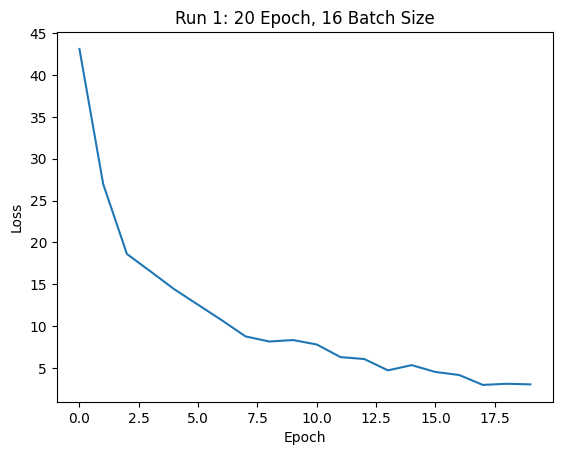

In [127]:
# Print the resulting total loss
# https://www.w3schools.com/python/matplotlib_plotting.asp

import matplotlib.pyplot as plt

# 4 epochs
epochs = [i for i in range(20)]

plt.plot(epochs, tot_loss)
plt.title("Run 1: 20 Epoch, 16 Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [124]:
# This is out of inclass activity 2
# It essentially just calculates the accuracy

def find_marked_categories(cat_dict):
    marked_categories = [category for category, value in cat_dict['cats'].items() if value == 1]
    return marked_categories[0]


def predict_and_evaluate(model, test_data):
    correct_predictions = 0
    predictions = []
    
    for text, true_labels in test_data:
        doc = model(text)
        prediction = doc.cats
        
        #print(doc.cats)
        
        highest_category = max(prediction, key=prediction.get)
        
        #print(highest_category)
        
        if find_marked_categories(true_labels) == highest_category:
            correct_predictions += 1

    return correct_predictions/len(test_data)


In [125]:
# Print the accuracy of the above model

accuracy = predict_and_evaluate(nlp, test_data)
print(accuracy)

0.856


In [126]:
# Run the second model with 20 epochs, batch size of 32
tot_loss2, nlp2 =  nn_spacy(20, 32, train_data)

Epoch:  0 Loss:  23.985561940819025
Epoch:  1 Loss:  14.61164697445929
Epoch:  2 Loss:  11.371415995061398
Epoch:  3 Loss:  9.953383424319327
Epoch:  4 Loss:  8.72553485375829
Epoch:  5 Loss:  7.192573974840343
Epoch:  6 Loss:  6.854784965282306
Epoch:  7 Loss:  7.407409028412076
Epoch:  8 Loss:  6.410981925291708
Epoch:  9 Loss:  6.504637277936126
Epoch:  10 Loss:  4.192364089387411
Epoch:  11 Loss:  3.6130747555287144
Epoch:  12 Loss:  4.749707789263994
Epoch:  13 Loss:  3.8757355334873864
Epoch:  14 Loss:  3.78777693843017
Epoch:  15 Loss:  3.4208840244591556
Epoch:  16 Loss:  3.3741247544785438
Epoch:  17 Loss:  2.2836178583183084
Epoch:  18 Loss:  2.6598182866566855
Epoch:  19 Loss:  1.8466944829907064


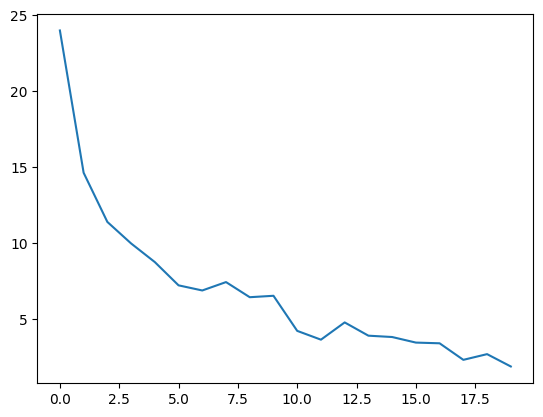

In [129]:
# Plot the loss of the second model

# https://www.w3schools.com/python/matplotlib_plotting.asp

import matplotlib.pyplot as plt

# 4 epochs
epochs = [i for i in range(20)]

plt.plot(epochs, tot_loss2)

In [130]:
# Plot the accuracy of the second model

accuracy2 = predict_and_evaluate(nlp2, test_data)
print(accuracy2)

0.853


In [131]:
# Run the third model with 25 epochs, 16 batch size
tot_loss3, nlp3 =  nn_spacy(25, 16, train_data)

Epoch:  0 Loss:  44.09535074606538
Epoch:  1 Loss:  25.807176963193342
Epoch:  2 Loss:  21.15216673631221
Epoch:  3 Loss:  18.041114428891888
Epoch:  4 Loss:  14.925335623764568
Epoch:  5 Loss:  13.04540546385033
Epoch:  6 Loss:  11.277485004491808
Epoch:  7 Loss:  9.649325501790965
Epoch:  8 Loss:  8.416979542371807
Epoch:  9 Loss:  7.401119018756269
Epoch:  10 Loss:  7.510559135175555
Epoch:  11 Loss:  6.70186527045404
Epoch:  12 Loss:  5.783525596305652
Epoch:  13 Loss:  6.429969282061897
Epoch:  14 Loss:  5.561238151199545
Epoch:  15 Loss:  5.1231643174967285
Epoch:  16 Loss:  4.554996934186153
Epoch:  17 Loss:  3.614915483236781
Epoch:  18 Loss:  2.856896684793402
Epoch:  19 Loss:  2.8320595233633385
Epoch:  20 Loss:  3.278129762986974
Epoch:  21 Loss:  3.806234324225139
Epoch:  22 Loss:  2.774676028236441
Epoch:  23 Loss:  2.6894096173792668
Epoch:  24 Loss:  2.7323915134053154


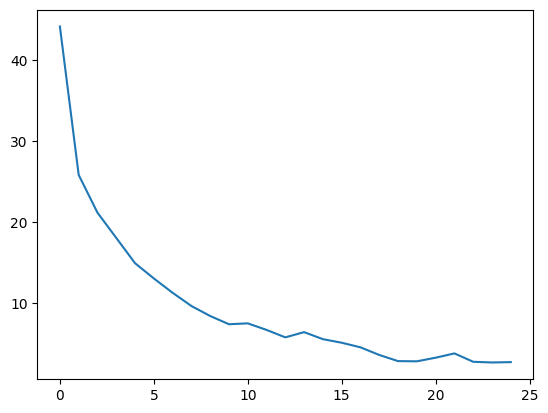

In [132]:
# plot the loss function of the third model

# https://www.w3schools.com/python/matplotlib_plotting.asp

import matplotlib.pyplot as plt

# 4 epochs
epochs = [i for i in range(25)]

plt.plot(epochs, tot_loss3)

In [133]:
# Get the accuracy of the third model
accuracy3 = predict_and_evaluate(nlp3, test_data)
print(accuracy3)

0.866


In [134]:
# Run the fourth model with 25 epochs, and 32 bach size
tot_loss4, nlp4 =  nn_spacy(25, 32, train_data)

Epoch:  0 Loss:  24.434871450066566
Epoch:  1 Loss:  15.089781299233437
Epoch:  2 Loss:  11.201039550825953
Epoch:  3 Loss:  10.36196797247976
Epoch:  4 Loss:  9.507490417454392
Epoch:  5 Loss:  7.193172138708178
Epoch:  6 Loss:  6.83811842148134
Epoch:  7 Loss:  5.679202409184654
Epoch:  8 Loss:  4.972137756689335
Epoch:  9 Loss:  5.105400752199785
Epoch:  10 Loss:  3.9298239498184557
Epoch:  11 Loss:  5.274235398188466
Epoch:  12 Loss:  3.6648990573594347
Epoch:  13 Loss:  3.4378701777727656
Epoch:  14 Loss:  3.2061065720674833
Epoch:  15 Loss:  3.1407711288380824
Epoch:  16 Loss:  3.3847959222882764
Epoch:  17 Loss:  4.324761222599491
Epoch:  18 Loss:  2.630813518768953
Epoch:  19 Loss:  2.556002399362767
Epoch:  20 Loss:  1.5434157664371921
Epoch:  21 Loss:  2.1688229305387834
Epoch:  22 Loss:  1.8419674584691772
Epoch:  23 Loss:  1.4931635618917054
Epoch:  24 Loss:  1.5868712594120884


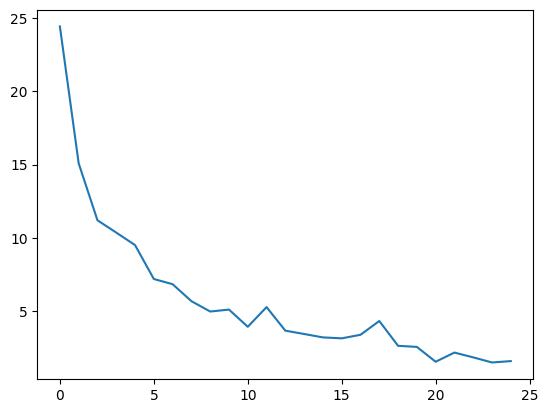

In [135]:
# Display a graph of the loss of the fourth model

# https://www.w3schools.com/python/matplotlib_plotting.asp

import matplotlib.pyplot as plt

# 4 epochs
epochs = [i for i in range(25)]

plt.plot(epochs, tot_loss4)

In [136]:
# Display the accuracy of the fourth model

accuracy4 = predict_and_evaluate(nlp4, test_data)
print(accuracy4)

0.827


In [ ]:
# Next I will use BERT to classify the text and compare the accuracy.

# The majority of the code is going to come from: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

# It will be fit to my dataset and problem.